In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json
from matplotlib_venn import venn2
from venn import venn

In [2]:
# transfers_df = pd.read_csv('../data/1_year/combined_transfers_1_year.csv')
transfers_df = pd.read_csv('../data/1_year/reduced_transfers_1_year.csv')

In [ ]:
# for token, group in transfers_df.groupby('token'):
#     group.to_csv(f'../data/1_year/distinct_tokens/{token}.csv', index=False)

## Comparison per token

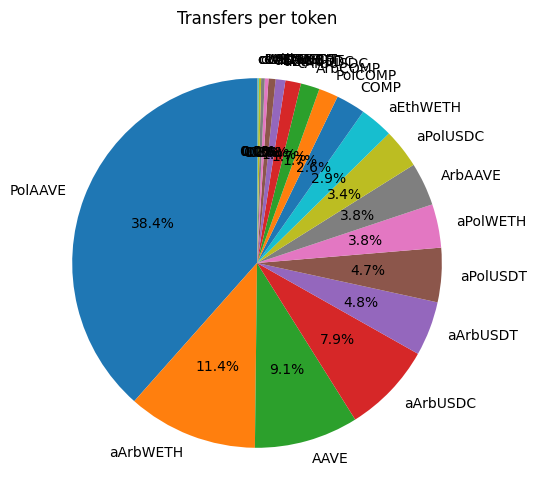

In [3]:
token_counts = transfers_df['token'].value_counts()

plt.figure(figsize=(8, 6))
token_counts.plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Transfers per token')
plt.ylabel('')
plt.show()

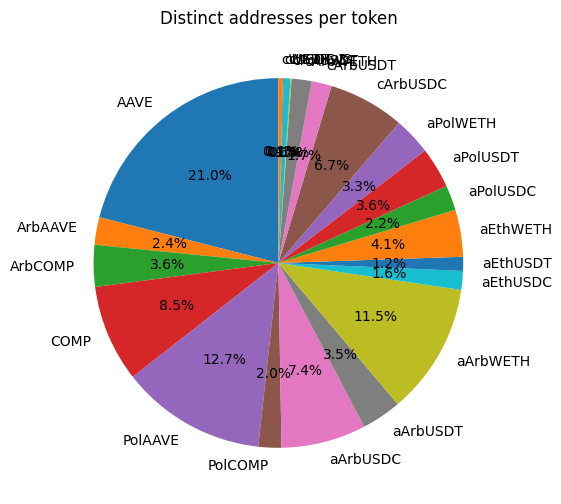

In [4]:
unique_addresses = pd.concat([transfers_df[['token', 'from']], transfers_df[['token', 'to']].rename(columns={'to': 'from'})])

address_counts = unique_addresses.groupby('token')['from'].nunique()

plt.figure(figsize=(8, 6))
address_counts.plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Distinct addresses per token')
plt.ylabel('')
plt.show()

In [ ]:
with open('../data/proposals/aave/aave_snapshot_votes_1_year.json', encoding='utf8') as f:
    aave_votes = json.load(f)

aave_voters = set()
for entry in aave_votes:
    for vote in entry['votes']:
        aave_voters.add(vote['voter'].lower())
        
with open('../data/proposals/compound/compound_votes_1_year.json', encoding='utf8') as f:
    compound_votes = json.load(f)

compound_voters = set()
for entry in compound_votes:
    for vote in entry['votes']:
        compound_voters.add(vote['voter']['id'].lower())

## Intersection analysis

In [6]:
governance_tokens = ['AAVE', 'ArbAAVE', 'PolAAVE', 'COMP', 'ArbCOMP', 'PolCOMP'] # , 'OptAAVE', 'OptCOMP', 'BasCOMP'
other_tokens = ['aEthWETH', 'aEthUSDT', 'aEthUSDC', 'cWETHv3', 'cUSDTv3', 'cUSDCv3', 'aPolWETH', 'aPolUSDC', 'aPolUSDT', 'cPolUSDT', 'aArbWETH', 'aArbUSDC', 'aArbUSDT', 'cArbWETH', 'cArbUSDC', 'cArbUSDT'] # , 'aOptWETH', 'aOptUSDC', 'aOptUSDT', 'cOptWETH', 'cOptUSDC', 'cOptUSDT', 'aBasWETH', 'aBasUSDC', 'cBasWETH', 'cBasUSDC'

In [7]:
governance_subset = transfers_df[transfers_df['token'].isin(governance_tokens)]
other_subset = transfers_df[transfers_df['token'].isin(other_tokens)]

governance_subset = set(governance_subset['from']).union(set(governance_subset['to']))
other_subset = set(other_subset['from']).union(set(other_subset['to']))

common_addresses = governance_subset.intersection(other_subset)
filtered_entries = transfers_df[transfers_df['from'].isin(common_addresses) & transfers_df['to'].isin(common_addresses)]

In [8]:
print(f'The number of distinct addresses per subset:\n- Governance: {len(governance_subset)}\n- Other: {len(other_subset)}')
print(f'\nThe intersection of both subsets:\n- Number of addresses: {len(common_addresses)}\n- Number of transfers: {len(filtered_entries)}')

The number of distinct addresses per subset:
- Governance: 250038
- Other: 184860

The intersection of both subsets:
- Number of addresses: 29557
- Number of transfers: 981543


In [9]:
filtered_entries_governance = filtered_entries[filtered_entries['token'].isin(governance_tokens)]
filtered_entries_other = filtered_entries[filtered_entries['token'].isin(other_tokens)]

In [ ]:
G_gov = nx.Graph()

for _, row in filtered_entries_governance.iterrows():
    G_gov.add_edge(row['from'], row['to'])
    
G_oth = nx.Graph()

for _, row in filtered_entries_other.iterrows():
    G_oth.add_edge(row['from'], row['to'])

In [ ]:
connected_components_gov = list(nx.connected_components(G_gov))

largest_component_gov = max(connected_components_gov, key=len)
largest_subgraph_gov = G_gov.subgraph(largest_component_gov)


connected_components_oth = list(nx.connected_components(G_oth))

largest_component_oth = max(connected_components_oth, key=len)
largest_subgraph_oth = G_oth.subgraph(largest_component_oth)

In [15]:
largest_gov_nodes = set(largest_component_gov)
cleaned_largest_gov = filtered_entries_governance[filtered_entries_governance['from'].isin(largest_gov_nodes) & filtered_entries_governance['to'].isin(largest_gov_nodes)]

largest_oth_nodes = set(largest_component_oth)
cleaned_largest_oth = filtered_entries_other[filtered_entries_other['from'].isin(largest_oth_nodes) & filtered_entries_other['to'].isin(largest_oth_nodes)]

In [ ]:
cleaned_largest_gov.to_csv('../data/1_year/largest_gov_component.csv', index=False)
cleaned_largest_oth.to_csv('../data/1_year/largest_oth_component.csv', index=False)

In [ ]:
gov_gn = nx.community.girvan_newman(largest_subgraph_gov)
tuple(sorted(c) for c in next(gov_gn))

In [9]:
from graspologic.plot import heatmap
from graspologic.partition import leiden

c:\Users\Sam\Documents\CS\Thesis\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
partition_map = leiden(G_gov)

labels = np.vectorize(partition_map.get)(list(G_gov.nodes))

A = nx.to_numpy_array(G_gov, nodelist=list(G_gov.nodes))
heatmap(A, inner_hier_labels=labels, sort_nodes=True, cbar=False)

In [17]:
cleaned_largest_gov['edge'] = cleaned_largest_gov.apply(lambda row: tuple(sorted([row['from'], row['to']])), axis=1)

gov_weighted_edges = cleaned_largest_gov.groupby('edge').size().reset_index(name='weight')
gov_weighted_edges[['from', 'to']] = pd.DataFrame(gov_weighted_edges['edge'].tolist(), index=gov_weighted_edges.index)
gov_weighted_edges = gov_weighted_edges.drop(columns=['edge'])

cleaned_largest_oth['edge'] = cleaned_largest_oth.apply(lambda row: tuple(sorted([row['from'], row['to']])), axis=1)

oth_weighted_edges = cleaned_largest_oth.groupby('edge').size().reset_index(name='weight')
oth_weighted_edges[['from', 'to']] = pd.DataFrame(oth_weighted_edges['edge'].tolist(), index=oth_weighted_edges.index)
oth_weighted_edges = oth_weighted_edges.drop(columns=['edge'])

C:\Users\Sam\AppData\Local\Temp\ipykernel_27100\3363344483.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_largest_gov['edge'] = cleaned_largest_gov.apply(lambda row: tuple(sorted([row['from'], row['to']])), axis=1)
C:\Users\Sam\AppData\Local\Temp\ipykernel_27100\3363344483.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_largest_oth['edge'] = cleaned_largest_oth.apply(lambda row: tuple(sorted([row['from'], row['to']])), axis=1)


In [ ]:
gov_weighted_edges.to_csv('../data/1_year/gov_weighted.csv', index=False)
oth_weighted_edges.to_csv('../data/1_year/oth_weighted.csv', index=False)

In [18]:
G_gov = nx.Graph()

for _, row in gov_weighted_edges.iterrows():
    G_gov.add_edge(row['from'], row['to'], weight=row['weight'])
    
G_oth = nx.Graph()

for _, row in oth_weighted_edges.iterrows():
    G_oth.add_edge(row['from'], row['to'], weight=row['weight'])

In [ ]:
# clustering_coefficient_gov = nx.average_clustering(largest_subgraph_gov)
clustering_coefficient_oth = nx.average_clustering(largest_subgraph_oth)

In [48]:
gov_degrees = dict(G_gov.degree())
average_gov_degree = sum(gov_degrees.values()) / len(gov_degrees)

oth_degrees = dict(G_oth.degree())
average_oth_degree = sum(oth_degrees.values()) / len(oth_degrees)

In [49]:
print(f'The average degrees compared to each other: \n- Governance token transfers: {average_gov_degree}\n- Other token transfers: {average_oth_degree}')

The average degrees compared to each other: 
- Governance token transfers: 2.9309916070873485
- Other token transfers: 2.773953805505838


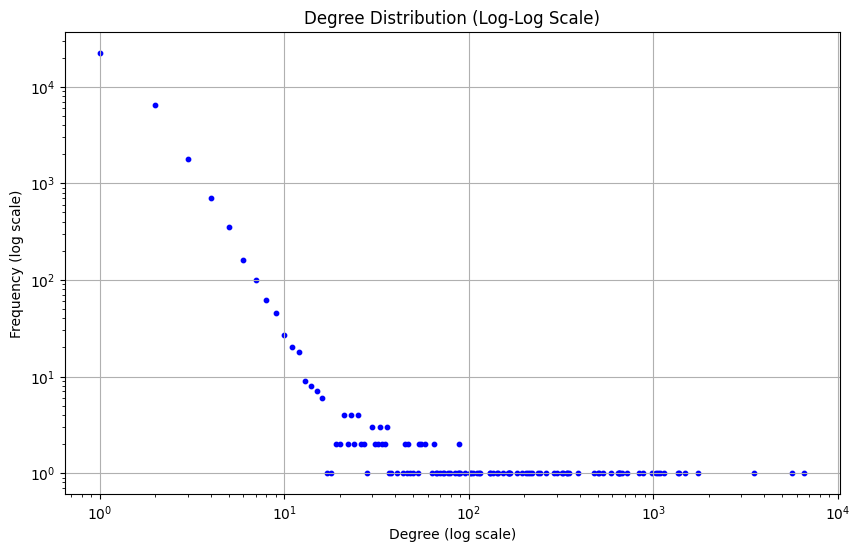

In [53]:
degree_sequence = [degree for node, degree in G_gov.degree()]
degree_count = np.bincount(degree_sequence)
degrees = np.arange(len(degree_count))

nonzero_degrees = degrees[degree_count > 0]
nonzero_counts = degree_count[degree_count > 0]

plt.figure(figsize=(10, 6))
plt.scatter(nonzero_degrees, nonzero_counts, color="blue", marker="o", s=10)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Degree (log scale)")
plt.ylabel("Frequency (log scale)")
plt.title("Degree Distribution (Log-Log Scale)")
plt.grid(True)
plt.show()

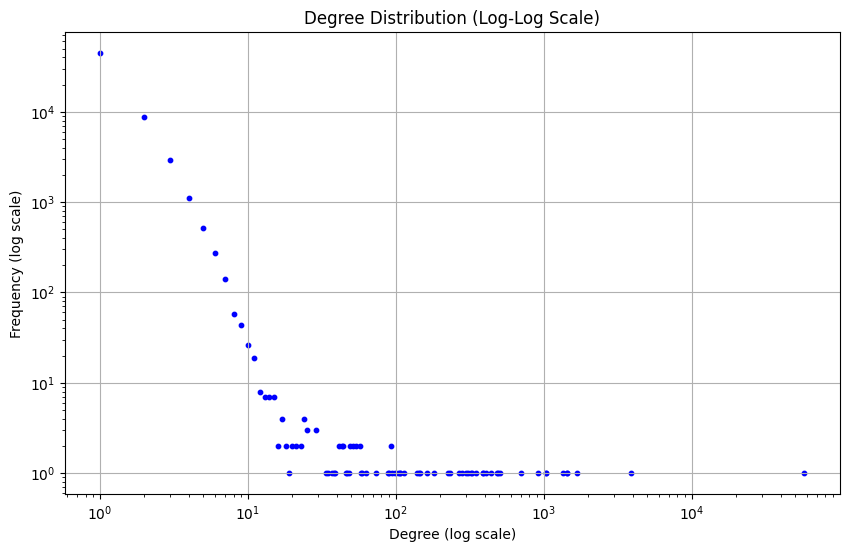

In [ ]:
degree_sequence = [degree for node, degree in G_oth.degree()]
degree_count = np.bincount(degree_sequence)
degrees = np.arange(len(degree_count))

nonzero_degrees = degrees[degree_count > 0]
nonzero_counts = degree_count[degree_count > 0]

plt.figure(figsize=(10, 6))
plt.scatter(nonzero_degrees, nonzero_counts, color="blue", marker="o", s=10)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Degree (log scale)")
plt.ylabel("Frequency (log scale)")
plt.title("Degree Distribution (Log-Log Scale)")
plt.grid(True)
plt.show()

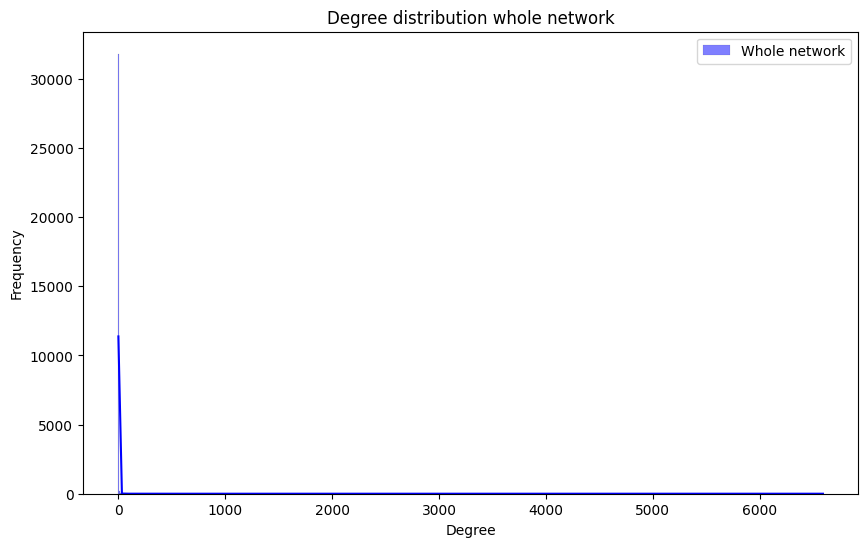

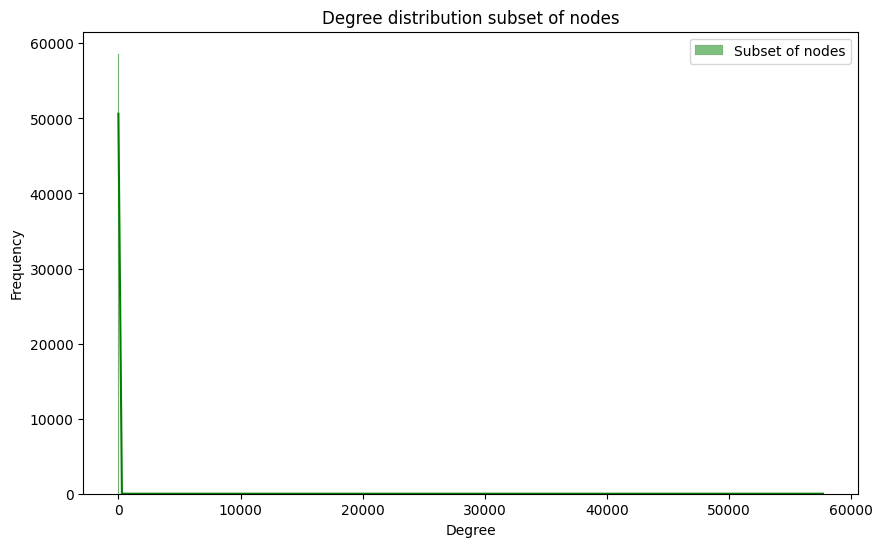

In [50]:
# del gov_degrees['0x0000000000000000000000000000000000000000']
# del oth_degrees['0x0000000000000000000000000000000000000000']

plt.figure(figsize=(10, 6))
sns.histplot(list(gov_degrees.values()), bins=1000, kde=True, color='blue', label='Whole network')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree distribution whole network')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(list(oth_degrees.values()), bins=1000, kde=True, color='green', label='Subset of nodes')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree distribution subset of nodes')
plt.legend()
plt.show()

In [ ]:
dict(sorted(gov_degrees.items(), key=lambda item: item[1], reverse=True))

In [ ]:
dict(sorted(oth_degrees.items(), key=lambda item: item[1], reverse=True))

## Cross-protocol analysis

### Entire set

In [11]:
aave_tokens = ['AAVE', 'ArbAAVE', 'PolAAVE', 'aEthWETH', 'aEthUSDT', 'aEthUSDC', 'aPolWETH', 'aPolUSDC', 'aPolUSDT', 'aArbWETH', 'aArbUSDC', 'aArbUSDT'] # , 'OptAAVE', 'aOptWETH', 'aOptUSDC', 'aOptUSDT', 'aBasWETH', 'aBasUSDC'
comp_tokens = ['COMP', 'ArbCOMP', 'PolCOMP', 'cWETHv3', 'cUSDTv3', 'cUSDCv3', 'cPolUSDT', 'cArbWETH', 'cArbUSDC', 'cArbUSDT'] # , 'OptCOMP', 'BasCOMP', 'cOptWETH', 'cOptUSDC', 'cOptUSDT', 'cBasWETH', 'cBasUSDC'

In [12]:
aave_addresses = transfers_df[transfers_df['token'].isin(aave_tokens)]
comp_addresses = transfers_df[transfers_df['token'].isin(comp_tokens)]

aave_addresses = set(aave_addresses['from']).union(set(aave_addresses['to']))
comp_addresses = set(comp_addresses['from']).union(set(comp_addresses['to']))

In [13]:
inter = len(aave_addresses.intersection(comp_addresses))
union = len(aave_addresses.union(comp_addresses))
left = len(aave_addresses - comp_addresses)
right = len(comp_addresses - aave_addresses)

Percentages of users per group:
- Using both platforms: 8.0%
- Using only Aave: 73.7%
- Using only Compound: 18.3%

Aave:
- Only using Aave: 90.2%
- Both: 9.8%

Compound:
- Only using Compound: 69.5%
- Both: 30.5%


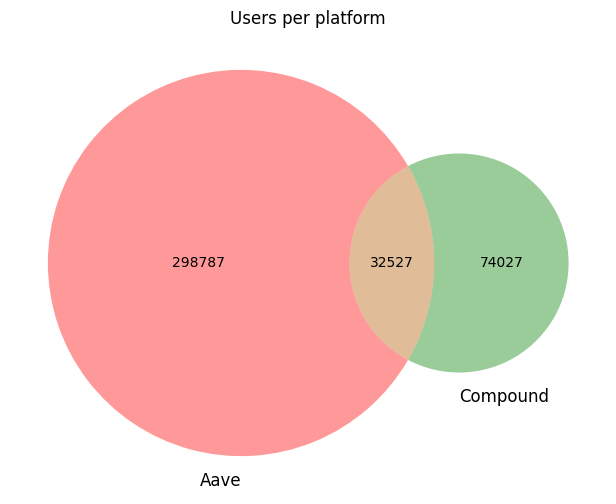

In [14]:
both = (inter / union) * 100
aave = (left / union) * 100
comp = (right / union) * 100
print(f'Percentages of users per group:\n- Using both platforms: {both:.1f}%\n- Using only Aave: {aave:.1f}%\n- Using only Compound: {comp:.1f}%\n')

both_aave = (inter / len(aave_addresses)) * 100
only_aave = ((len(aave_addresses) - inter) / len(aave_addresses)) * 100
both_comp = (inter / len(comp_addresses)) * 100
only_comp = ((len(comp_addresses) - inter) / len(comp_addresses)) * 100

print(f'Aave:\n- Only using Aave: {only_aave:.1f}%\n- Both: {both_aave:.1f}%\n')
print(f'Compound:\n- Only using Compound: {only_comp:.1f}%\n- Both: {both_comp:.1f}%')

plt.figure(figsize=(8, 6))
venn = venn2([aave_addresses, comp_addresses], set_labels=('Aave', 'Compound'))
plt.title("Users per platform")
plt.show()

### Governance

In [11]:
gov_aave_tokens = ['AAVE', 'ArbAAVE', 'PolAAVE'] # , 'OptAAVE']
gov_comp_tokens = ['COMP', 'ArbCOMP', 'PolCOMP'] # , 'OptCOMP', 'BasCOMP']

In [12]:
gov_aave_addresses = transfers_df[transfers_df['token'].isin(gov_aave_tokens)]
gov_comp_addresses = transfers_df[transfers_df['token'].isin(gov_comp_tokens)]

gov_aave_addresses = set(gov_aave_addresses['from']).union(set(gov_aave_addresses['to']))
gov_comp_addresses = set(gov_comp_addresses['from']).union(set(gov_comp_addresses['to']))

In [17]:
gov_inter = len(gov_aave_addresses.intersection(gov_comp_addresses))
gov_union = len(gov_aave_addresses.union(gov_comp_addresses))
gov_left = len(gov_aave_addresses - gov_comp_addresses)
gov_right = len(gov_comp_addresses - gov_aave_addresses)

Percentages of users per group:
- Using both platforms: 5.6%
- Using only Aave: 70.2%
- Using only Compound: 24.3%

Aave:
- Only using Aave: 92.7%
- Both: 7.3%

Compound:
- Only using Compound: 81.4%
- Both: 18.6%


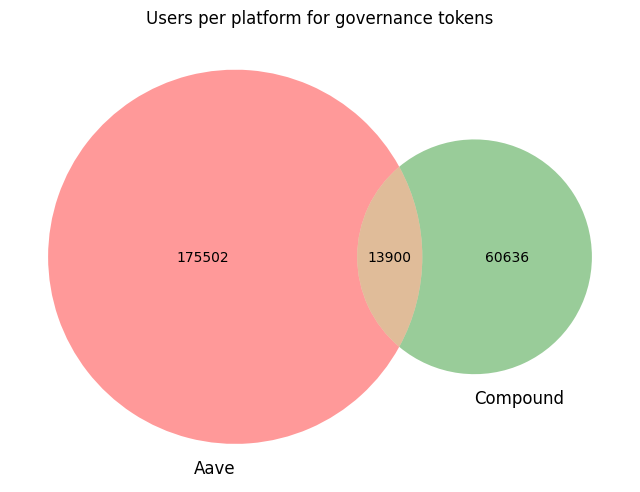

In [18]:
both = (gov_inter / gov_union) * 100
aave = (gov_left / gov_union) * 100
comp = (gov_right / gov_union) * 100
print(f'Percentages of users per group:\n- Using both platforms: {both:.1f}%\n- Using only Aave: {aave:.1f}%\n- Using only Compound: {comp:.1f}%\n')

both_aave = (gov_inter / len(gov_aave_addresses)) * 100
only_aave = ((len(gov_aave_addresses) - gov_inter) / len(gov_aave_addresses)) * 100
both_comp = (gov_inter / len(gov_comp_addresses)) * 100
only_comp = ((len(gov_comp_addresses) - gov_inter) / len(gov_comp_addresses)) * 100

print(f'Aave:\n- Only using Aave: {only_aave:.1f}%\n- Both: {both_aave:.1f}%\n')
print(f'Compound:\n- Only using Compound: {only_comp:.1f}%\n- Both: {both_comp:.1f}%')

plt.figure(figsize=(8, 6))
venn = venn2([gov_aave_addresses, gov_comp_addresses], set_labels=('Aave', 'Compound'))
plt.title("Users per platform for governance tokens")
plt.show()

### Other

In [5]:
oth_aave_tokens = ['aEthWETH', 'aEthUSDT', 'aEthUSDC', 'aPolWETH', 'aPolUSDC', 'aPolUSDT', 'aArbWETH', 'aArbUSDC', 'aArbUSDT'] # , 'aOptWETH', 'aOptUSDC', 'aOptUSDT', 'aBasWETH', 'aBasUSDC']
oth_comp_tokens = ['cWETHv3', 'cUSDTv3', 'cUSDCv3', 'cPolUSDT', 'cArbWETH', 'cArbUSDC', 'cArbUSDT'] # , 'cOptWETH', 'cOptUSDC', 'cOptUSDT', 'cBasWETH', 'cBasUSDC']

In [6]:
oth_aave_addresses = transfers_df[transfers_df['token'].isin(oth_aave_tokens)]
oth_comp_addresses = transfers_df[transfers_df['token'].isin(oth_comp_tokens)]

oth_aave_addresses = set(oth_aave_addresses['from']).union(set(oth_aave_addresses['to']))
oth_comp_addresses = set(oth_comp_addresses['from']).union(set(oth_comp_addresses['to']))

In [7]:
oth_inter = len(oth_aave_addresses.intersection(oth_comp_addresses))
oth_union = len(oth_aave_addresses.union(oth_comp_addresses))
oth_left = len(oth_aave_addresses - oth_comp_addresses)
oth_right = len(oth_comp_addresses - oth_aave_addresses)

Percentages of users per group:
- Using both platforms: 8.9%
- Using only Aave: 75.8%
- Using only Compound: 15.3%

Aave:
- Only using Aave: 89.5%
- Both: 10.5%

Compound:
- Only using Compound: 63.3%
- Both: 36.7%


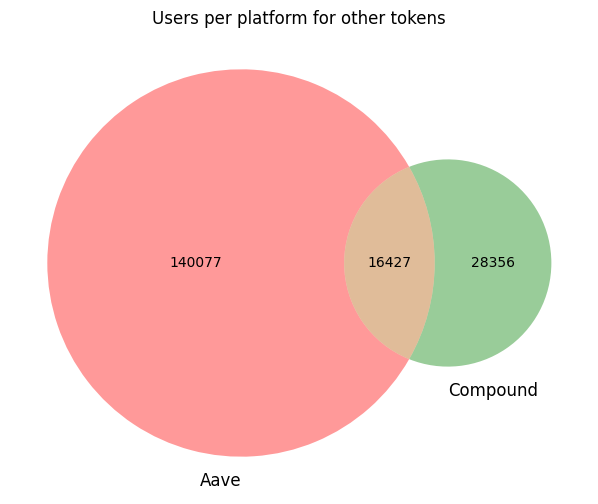

In [8]:
both = (oth_inter / oth_union) * 100
aave = (oth_left / oth_union) * 100
comp = (oth_right / oth_union) * 100
print(f'Percentages of users per group:\n- Using both platforms: {both:.1f}%\n- Using only Aave: {aave:.1f}%\n- Using only Compound: {comp:.1f}%\n')

both_aave = (oth_inter / len(oth_aave_addresses)) * 100
only_aave = ((len(oth_aave_addresses) - oth_inter) / len(oth_aave_addresses)) * 100
both_comp = (oth_inter / len(oth_comp_addresses)) * 100
only_comp = ((len(oth_comp_addresses) - oth_inter) / len(oth_comp_addresses)) * 100

print(f'Aave:\n- Only using Aave: {only_aave:.1f}%\n- Both: {both_aave:.1f}%\n')
print(f'Compound:\n- Only using Compound: {only_comp:.1f}%\n- Both: {both_comp:.1f}%')

plt.figure(figsize=(8, 6))
venn = venn2([oth_aave_addresses, oth_comp_addresses], set_labels=('Aave', 'Compound'))
plt.title("Users per platform for other tokens")
plt.show()

<Axes: >

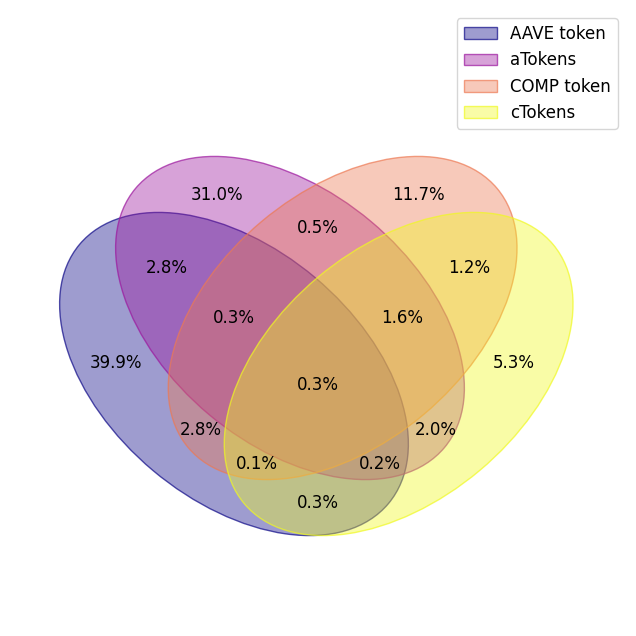

In [14]:
subsets = {
    "AAVE token": gov_aave_addresses,
    "aTokens": oth_aave_addresses,
    "COMP token": gov_comp_addresses,
    "cTokens": oth_comp_addresses
}

venn(subsets, fmt="{percentage:.1f}%", cmap='plasma', fontsize=12)